In [572]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind
import datetime
from matplotlib.dates import DateFormatter

In [573]:
transaction = pd.read_excel("QVI_transaction_data.xls")
print(transaction.shape)
transaction.head()



(65535, 8)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [574]:
#Change the date format
def xlseriesdate_to_datetime(xlserialdate):
    excel_anchor = datetime.datetime(1900, 1, 1)
    if(xlserialdate < 60):
        delta_in_days = datetime.timedelta(days = (xlserialdate - 1))
    else:
        delta_in_days = datetime.timedelta(days = (xlserialdate - 2))
    converted_date = excel_anchor + delta_in_days
    return converted_date
transaction['DATE'] = transaction['DATE'].apply(xlseriesdate_to_datetime)
transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [575]:
#check missing data in transaction data
transaction.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

Based on the summary above, there were no missing data in two files.

In [576]:
#Checking the data type
transaction.dtypes

DATE              datetime64[ns]
STORE_NBR                  int64
LYLTY_CARD_NBR             int64
TXN_ID                     int64
PROD_NBR                   int64
PROD_NAME                 object
PROD_QTY                   int64
TOT_SALES                float64
dtype: object

In [577]:
#Extracting the Quantity from PROD_NAME
transaction['PROD_WEIGHT']=transaction['PROD_NAME'].str.extract('(\d+)')
transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGHT
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


In [578]:
#Drop rows with salsa word and removing special characters.
transaction['PROD_NAME']=transaction['PROD_NAME'].str.replace('(\d+g)|(&)',"")
transaction=transaction[~transaction['PROD_NAME'].str.contains(('Salsa|salsa'),regex=True)]
transaction["PROD_WEIGHT"]=transaction["PROD_WEIGHT"].astype(float)
transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGHT
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt,2,6.0,175.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175.0
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170.0
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/CreamOnion,5,15.0,175.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHnyJlpno Chili,3,13.8,150.0


In [579]:
# Extract brand name from PROD_NAME and create new column called BRAND
part = transaction['PROD_NAME'].str.partition()
transaction['BRAND'] = part[0]
transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGHT,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt,2,6.0,175.0,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175.0,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170.0,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/CreamOnion,5,15.0,175.0,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHnyJlpno Chili,3,13.8,150.0,Kettle


In [580]:
transaction['BRAND'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [581]:
#Rename brand names
transaction['BRAND'].replace('NCC', 'Natural', inplace = True)
transaction['BRAND'].replace('CCs', 'CCS', inplace = True)
transaction['BRAND'].replace('Smith', 'Smiths', inplace = True)
transaction['BRAND'].replace(['Grain', 'GrnWves'], 'Grainwaves', inplace = True)
transaction['BRAND'].replace('Dorito', 'Doritos', inplace = True)
transaction['BRAND'].replace('WW', 'Woolworths', inplace = True)
transaction['BRAND'].replace('Infzns', 'Infuzions', inplace = True)
transaction['BRAND'].replace(['Red','RRD'] ,'Red Rock Deli', inplace = True)
transaction['BRAND'].replace('Snbts', 'Sunbites', inplace = True)

transaction['BRAND'].unique()

array(['Natural', 'CCS', 'Smiths', 'Kettle', 'Grainwaves', 'Doritos',
       'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

In [582]:
#Finding the unique value in the transaction data
print("The unique data:\n",transaction.nunique(),"\n")
#See which value are present in particular column
print("Product_quantity:\n",transaction['PROD_QTY'].value_counts(),"\n")
print("DATE:\n",transaction['DATE'].value_counts(),"\n")
print("Brand:\n",transaction['BRAND'].value_counts(),"\n")
print("Product_weight:\n",transaction['PROD_WEIGHT'].value_counts(),"\n")

The unique data:
 DATE                364
STORE_NBR           265
LYLTY_CARD_NBR    16314
TXN_ID            60577
PROD_NBR            105
PROD_NAME           105
PROD_QTY              5
TOT_SALES            99
PROD_WEIGHT          20
BRAND                20
dtype: int64 

Product_quantity:
 2    55137
1     5562
5      123
3       97
4       91
Name: PROD_QTY, dtype: int64 

DATE:
 2018-12-24    224
2018-12-20    222
2018-12-23    210
2018-12-22    202
2018-12-19    201
             ... 
2018-08-25    139
2018-12-01    139
2019-03-09    138
2018-07-24    135
2018-07-28    134
Name: DATE, Length: 364, dtype: int64 

Brand:
 Kettle           9969
Smiths           7736
Doritos          6092
Pringles         5954
Red Rock Deli    4328
Infuzions        3504
Thins            3396
Woolworths       3081
Cobs             2373
Twisties         2314
Tostitos         2232
Natural          1944
Grainwaves       1918
Tyrrells         1518
CCS              1185
Cheezels         1161
Cheetos          

In [583]:
#As we can see, the date column only has 364 unique values, using the method to see which day is the missing date
pd.date_range(start=merged_data["DATE"].min(), end=merged_data["DATE"].max()).difference(merged_data["DATE"])

DatetimeIndex(['1970-01-01 00:00:00.000043282'], dtype='datetime64[ns]', freq=None)

In [584]:
#Checking the data
purchase = pd.read_csv("QVI_purchase_behaviour.csv")
purchase.head()
print(purchase.shape)

(72637, 3)


In [585]:
#Check missing data in purchase behaviour data
purchase.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [586]:
#Checking the data type
purchase.dtypes

LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object

In [587]:
#Finding the unique value in the purchase data
print("The unique data:\n",purchase.nunique(),"\n")
#See which value are present in particular column
print("Lifestage:\n",purchase['LIFESTAGE'].value_counts(),"\n")
print("Premium Customer:\n",purchase['PREMIUM_CUSTOMER'].value_counts(),"\n")
#Calculate the most common type
purchase.value_counts().idxmax()

The unique data:
 LYLTY_CARD_NBR      72637
LIFESTAGE               7
PREMIUM_CUSTOMER        3
dtype: int64 

Lifestage:
 RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64 

Premium Customer:
 Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64 



(2373711, 'YOUNG SINGLES/COUPLES', 'Mainstream')

In [588]:
merged_data=pd.merge(transaction,purchase,how="left",on="LYLTY_CARD_NBR")
print(merged_data.shape)
merged_data.head()

(61010, 12)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGHT,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt,2,6.0,175.0,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175.0,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170.0,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/CreamOnion,5,15.0,175.0,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHnyJlpno Chili,3,13.8,150.0,Kettle,MIDAGE SINGLES/COUPLES,Budget


In [589]:
#check the data format
merged_data.dtypes

DATE                datetime64[ns]
STORE_NBR                    int64
LYLTY_CARD_NBR               int64
TXN_ID                       int64
PROD_NBR                     int64
PROD_NAME                   object
PROD_QTY                     int64
TOT_SALES                  float64
PROD_WEIGHT                float64
BRAND                       object
LIFESTAGE                   object
PREMIUM_CUSTOMER            object
dtype: object

In [590]:
merged_data.nunique()

DATE                  364
STORE_NBR             265
LYLTY_CARD_NBR      16314
TXN_ID              60577
PROD_NBR              105
PROD_NAME             105
PROD_QTY                5
TOT_SALES              99
PROD_WEIGHT            20
BRAND                  20
LIFESTAGE               4
PREMIUM_CUSTOMER        3
dtype: int64

In [591]:
merged_data.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PROD_WEIGHT         0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [592]:
merged_data['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES',
       'OLDER FAMILIES'], dtype=object)

In [593]:
merged_data['PREMIUM_CUSTOMER'].unique()

array(['Premium', 'Budget', 'Mainstream'], dtype=object)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PROD_QTY', ylabel='TOT_SALES'>

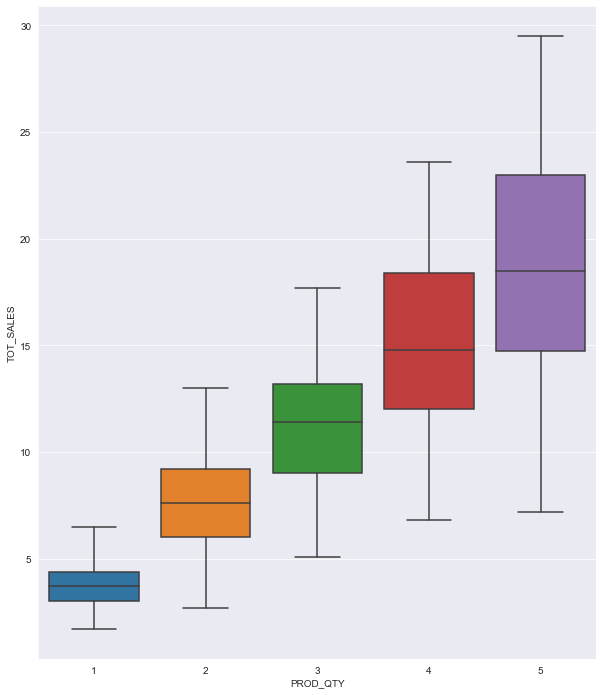

In [594]:
# Checking outliners in PROD_QTY and TOT_SALES
plt.figure(figsize=(10,12))
sns.boxplot(merged_data.PROD_QTY,merged_data.TOT_SALES)

In [595]:
# Create a new dataframe which contains the total sale for each date
date_total_1= pd.pivot_table(transaction, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
date_total_1.head()

,TOT_SALES
DATE,
2018-07-01,1246.0
2018-07-02,1284.7
2018-07-03,1181.7
2018-07-04,1203.5
2018-07-05,1189.2


In [596]:
date_total_2=pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
date_total_2['TOT_SALES'] = 0
date_total = date_total_1+date_total_2
date_total.fillna(0, inplace = True)
date_total.index.name = 'Date'
date_total.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
date_total.head()

,Total Sales
Date,
2018-07-01,1246.0
2018-07-02,1284.7
2018-07-03,1181.7
2018-07-04,1203.5
2018-07-05,1189.2


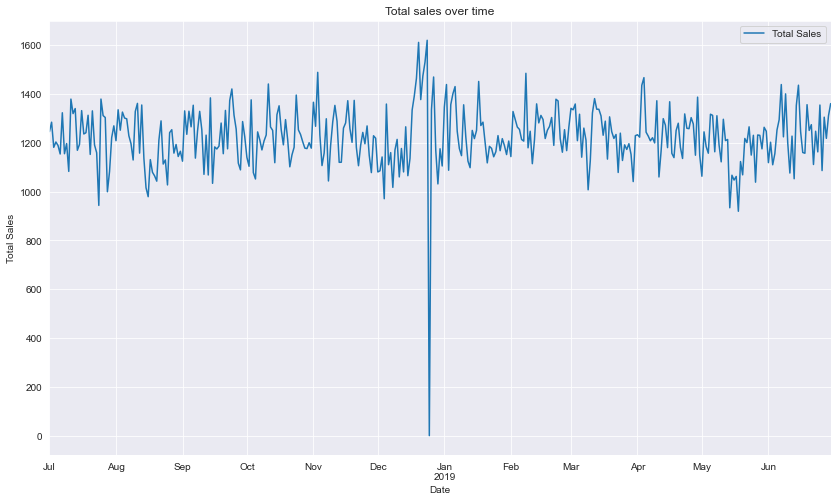

In [597]:
# See the total sales over the year
date_total.plot(kind='line',figsize=(14,8))
plt.title('Total sales over time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

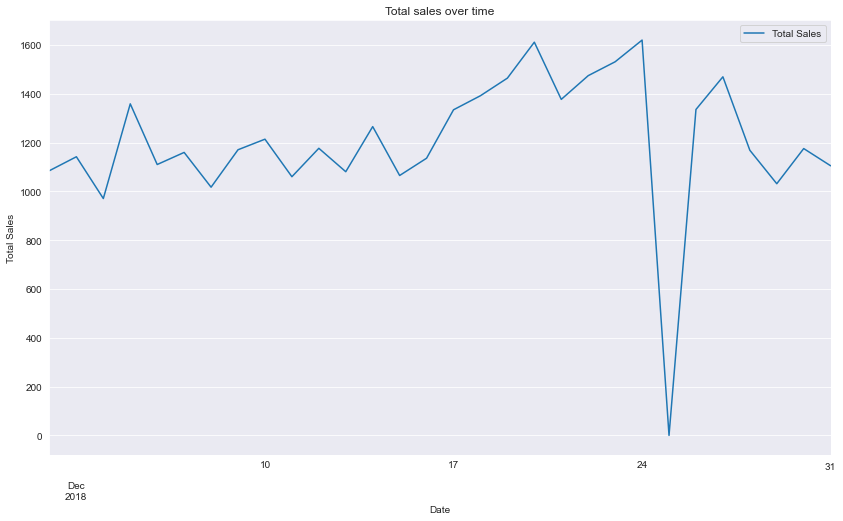

In [598]:
#See the December total sales
Dec_date_total = date_total[(date_total.index > "2018-12-1") & (date_total.index < "2019-1-1")]
Dec_date_total.plot(kind='line',figsize=(14,8))
plt.title('Total sales over time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()


Text(0.5, 1.0, 'Pack Size frequency')

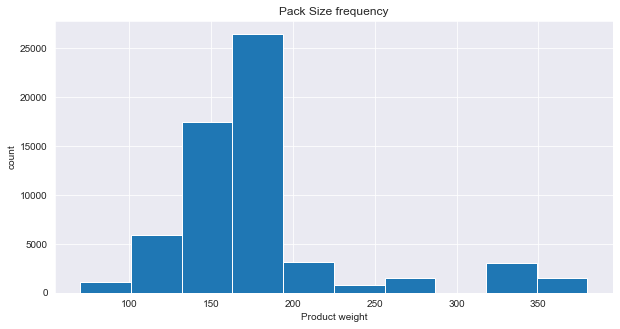

In [636]:
#Most frequently purchased product weight 
plt.figure(figsize = (10, 5))
plt.hist(merged_data['PROD_WEIGHT'])     
plt.xlabel('Product weight')
plt.ylabel('count')
plt.title('Pack Size frequency')

<AxesSubplot:xlabel='Product weight and Total sales ', ylabel='TOT_SALES'>

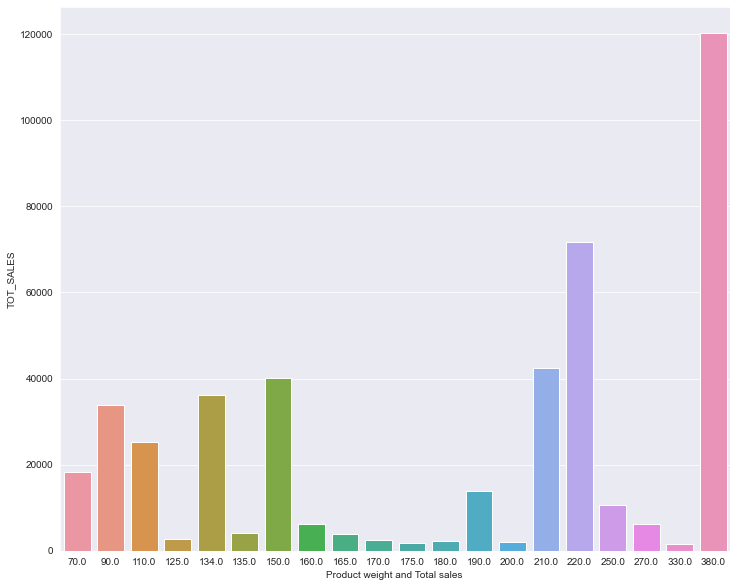

In [603]:
#Which packet size producing highest total sales
plt.figure(figsize=(12,10))
plt.xlabel("Product weight and Total sales ")
sns.barplot(y=merged_data.groupby("PROD_WEIGHT").TOT_SALES.sum(), x=merged_data.PROD_WEIGHT.unique())


<AxesSubplot:xlabel='Brand name', ylabel='BRAND'>

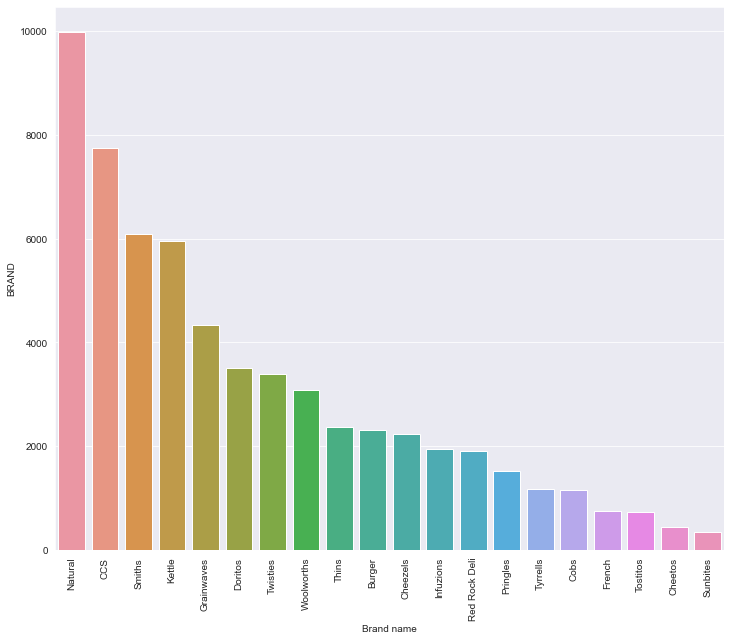

In [610]:
# Most frequently purchased brand name
plt.figure(figsize=(12,10))
plt.xlabel("Brand")
plt.xticks(rotation=90) 
sns.barplot(y=merged_data.BRAND.value_counts(),x=merged_data.BRAND.unique())

<AxesSubplot:xlabel='Brand', ylabel='TOT_SALES'>

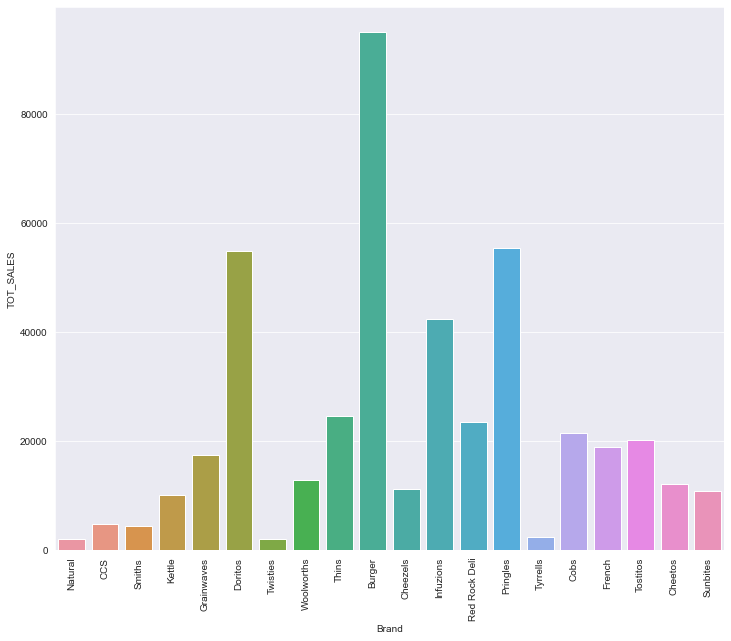

In [611]:
# Brand producing highest total sales
plt.figure(figsize=(12,10))
plt.xlabel("Brand")
plt.xticks(rotation=90) 
sns.barplot(y=merged_data.groupby('BRAND').TOT_SALES.sum(),x=merged_data.BRAND.unique())

In [601]:
life_pre_Sales=merged_data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).sum().sort_values(by=["PREMIUM_CUSTOMER","TOT_SALES"],ascending=False)
life_pre_Sales=life_pre_Sales['TOT_SALES'].sort_values(ascending=False)
life_pre_Sales=life_pre_Sales.reset_index(inplace=False)
life_pre_Sales.head()

,PREMIUM_CUSTOMER,LIFESTAGE,TOT_SALES
0,Budget,OLDER FAMILIES,156863.75
1,Mainstream,MIDAGE SINGLES/COUPLES,84734.25
2,Mainstream,OLDER FAMILIES,69375.45
3,Premium,MIDAGE SINGLES/COUPLES,54443.85
4,Budget,MIDAGE SINGLES/COUPLES,33345.70


In [613]:
grouped_sales = pd.DataFrame(merged_data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"].agg(["sum", "mean"]))
grouped_sales.sort_values(ascending=False, by="sum")

sum      mean
LIFESTAGE              PREMIUM_CUSTOMER                     
OLDER FAMILIES         Budget            156863.75  7.291241
MIDAGE SINGLES/COUPLES Mainstream         84734.25  7.637156
OLDER FAMILIES         Mainstream         69375.45  7.226609
MIDAGE SINGLES/COUPLES Premium            54443.85  7.152371
                       Budget             33345.70  7.108442
NEW FAMILIES           Budget             20607.45  7.297256
                       Mainstream         15979.70  7.313364
                       Premium            10760.80  7.231720
YOUNG SINGLES/COUPLES  Premium                6.00  6.000000

(-1.2293561677271538, 1.232352318833505, -1.1959555752870865, 1.1984777798845)

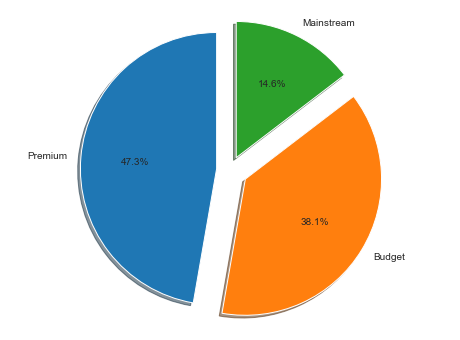

In [630]:
labels = merged_data.PREMIUM_CUSTOMER.unique()
sizes=merged_data.groupby("PREMIUM_CUSTOMER").TOT_SALES.sum()
explode=[0.1,0.13,0.1]
plt.figure(figsize=(8,6))
plt.pie(sizes,explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

(-1.2238324824091698,
 1.2135046458160483,
 -1.2307906773606188,
 1.210990032166341)

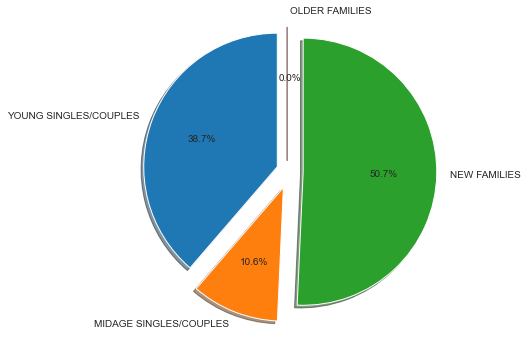

In [633]:
labels = merged_data.LIFESTAGE.unique()
sizes = merged_data.groupby("LIFESTAGE").TOT_SALES.sum()
explode=[0.1,0.13,0.1,0.1]
plt.figure(figsize=(8,6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal') 

Conclusion:
The Burger brand has highest total sales , but the natural is the most frequently purchased brand.
The most frequently purcahse product weight around 135-175, but product weight with 380 has highest total sales.
Sales are highest for New families and Premium.
